In [203]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sqlalchemy import create_engine
import MySQLdb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from statsmodels.discrete.discrete_model import Logit, MNLogit
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import statsmodels.api as st
from imblearn.under_sampling import ClusterCentroids
import numpy as np
import scikitplot as skplt
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 50)

In [204]:
# import data
# feature engineering?
# k fold
# hyperparameter tuning
# Hospital Insurance -> classification
# Hospital Utilisation -> classification
# performance measure

In [205]:
# # DB Connection
# myvars = {}
# with open("../risaac-mysql-password") as myfile:
#     for line in myfile:
#         name, var = line.partition(":")[::2]
#         myvars[name.strip()] = var.strip()
        
# myvars['DB databasename'] = 'I501saptpurkFall22grp_06_db'

# conn = MySQLdb.connect(host="localhost", user=myvars['DB username'], passwd=myvars['DB password'], db=myvars['DB databasename'])
# cursor = conn.cursor()

In [206]:
# df = pd.read_sql('select * from P_DEMO_HUQ_HIQ', conn)
df = pd.read_csv("P_DEMO_HUQ_HIQ.csv")

In [207]:
# remove INDFMPIR and replace with INDFMPIR_imputed
df = df.drop("INDFMPIR", axis = 1)
df = df[~df.isna().any(axis = 1)]
df = df.rename(columns = {"INDFMPIR_imputed":"INDFMPIR"})

# copy dataframe
df_temp = df.copy()

In [208]:
# segragating features into nominal, ordinal and numeric
nominal_cols = [
    "RIAGENDR"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"HUQ030"
    ,"HUQ071"
    ,"HUQ090"
    ,"HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210'
]

ordinal_cols = [
    "DMDYRUSZ"
    ,"DMDEDUC2"
    ,"HUQ010"
    ,"HUQ051"
]

numeric_cols = [
    "RIDAGEYR"
    ,"RIDAGEMN"
    ,"INDFMPIR"
]

In [209]:
ordinal_cols_wo_Target = ordinal_cols = [
    "DMDYRUSZ"
    ,"DMDEDUC2"
    ,"HUQ010"
]

In [210]:
# columns to one hot encode
# RIDRETH3
# RIDRETH1
# DMDBORN4 - Encode to 0,1
# DMDMARTZ
# RIDEXPRG
# SIALANG - Encode to 0,1
# SIAPROXY - Encode to 0,1
# SIAINTRP - Encode to 0,1

# HUQ030
# HUQ071 - Encode to 0,1
# HUQ090 - Encode to 0,1
# HIQ011 - Encode to 0,1
# HIQ032A - Encode to 0,1

# HIQ270
# HIQ210

In [211]:
# covert 1=>0, 2=>1
enc_1_0_cols = ["DMDBORN4"
               ,"SIALANG"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 0, 1)
    
# covert 1=>1, 2=>0
enc_1_0_cols = ["SIAPROXY"
               ,"SIAINTRP"
               ,"HUQ071"
               ,"HUQ090"
               ,"HIQ011"
               ,"HIQ032A"]
for col in enc_1_0_cols:
    df[col] = np.where(df[col] == 1, 1, 0)


In [212]:
one_hot_enc_cols = ["RIDRETH3"
                   ,"RIDRETH1"
                   ,"DMDMARTZ"
                   ,"RIDEXPRG"
                   ,"HUQ030"
                   ,"HIQ270"
                   ,"HIQ210"]

In [213]:
df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]] = df[["HUQ051","HUQ030","HUQ010","HIQ210","HIQ270"]].astype("Int32")

In [214]:
demo_cols = [
    "RIAGENDR"
    ,"RIDAGEMN"
    ,"RIDRETH1"
    ,"RIDRETH3"
    ,"DMDBORN4"
    ,"DMDMARTZ"
    ,"RIDEXPRG"
    ,"SIALANG"
    ,"SIAPROXY"
    ,"SIAINTRP"
    ,"DMDYRUSZ"
    ,"DMDEDUC2"
    ,"INDFMPIR"
]

huq_cols = ["HUQ010"
           ,"HUQ071"
           ,"HUQ090"
           ,"HUQ051"]

hiq_cols = ["HIQ011"
    ,'HIQ032A'
    ,'HIQ032B'
    ,'HIQ032C'
    ,'HIQ032D'
    ,'HIQ032E'
    ,'HIQ032H'
    ,'HIQ032I'
    ,'HIQ270'
    ,'HIQ210']

### Hospital Utilisation Prediction Using Demographics & Health Insurance

In [215]:
target_col = "HUQ051"

In [216]:
# convert hospital utilisation to three class
df.loc[df["HUQ051"].isin([0,1,2]), "HUQ051"] = 0 # low utilisation
df.loc[df["HUQ051"].isin([3,4,5]), "HUQ051"] = 1 # moderate utilisation
# df.loc[df["HUQ051"].isin([4,5]), "HUQ051"] = 2 # high utilisation
df.loc[df["HUQ051"] >= 6, "HUQ051"] = 2 # high utilisation

In [217]:
df_dum = pd.get_dummies(df[demo_cols + hiq_cols + huq_cols], columns = [col for col in one_hot_enc_cols if col in demo_cols + huq_cols + hiq_cols], drop_first = True)

In [218]:
# df_dum = st.add_constant(df_dum, prepend = False)

In [219]:
X_train, X_test, y_train, y_test = train_test_split(df_dum[df_dum.columns[df_dum.columns != target_col]], 
                                                    df_dum[target_col], 
                                                    test_size=0.20
                                                    )

In [220]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)
    
for col in X_test.columns:
    X_test[col] = X_test[col].astype(float)

In [221]:
y_train = y_train.astype(int)

In [222]:
sm = SMOTE()

In [223]:
X_train, y_train = sm.fit_resample(X_train, y_train)

### Logistic Regression

In [224]:
# based on statsmodel multinomial logit
mdl = st.MNLogit(y_train, X_train)
mdl_fit = mdl.fit()
print(mdl_fit.summary())

Optimization terminated successfully.
         Current function value: 0.931705
         Iterations 11
                          MNLogit Regression Results                          
Dep. Variable:                 HUQ051   No. Observations:                23811
Model:                        MNLogit   Df Residuals:                    23743
Method:                           MLE   Df Model:                           66
Date:                Sat, 03 Dec 2022   Pseudo R-squ.:                  0.1519
Time:                        20:36:55   Log-Likelihood:                -22185.
converged:                       True   LL-Null:                       -26159.
Covariance Type:            nonrobust   LLR p-value:                     0.000
  HUQ051=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
RIAGENDR       0.2385      0.039      6.078      0.000       0.162       0.315
RIDAGEMN      -0.0002      0

In [225]:
# filter significant columns based on p value
out = mdl_fit.summary()
out = out.tables[1].as_html()
out = pd.read_html(out, header=0, index_col=0)[0]

In [226]:
# separate both static tables
out1 = out.iloc[:39]
out2 = out.iloc[39:]
out2.columns = out2.iloc[0]
out2 = out2.iloc[1:]

In [25]:
out = pd.DataFrame({"HUQ051=1":out1['P>|z|'], "HUQ051=2":out2['P>|z|']})

In [26]:
out = out.astype(float)

In [27]:
out["HUQ051=1"][out["HUQ051=1"] > 0.1], out["HUQ051=2"][out["HUQ051=2"] > 0.1]

(HUQ051=1
 SIALANG       0.995
 HIQ032C       0.394
 HIQ032E       0.148
 RIDRETH3_3    1.000
 RIDRETH1_3    1.000
 DMDMARTZ_2    0.459
 HIQ270_3      1.000
 HIQ210_3      1.000
 Name: HUQ051=1, dtype: float64,
 HUQ051=1
 DMDBORN4      0.184
 INDFMPIR      0.525
 RIDRETH3_4    1.000
 RIDRETH3_6    1.000
 RIDRETH3_7    1.000
 RIDRETH1_4    1.000
 RIDRETH1_5    1.000
 DMDMARTZ_2    0.134
 HIQ210_2      0.726
 Name: HUQ051=2, dtype: float64)

In [28]:
new_cols = out[(out["HUQ051=1"] > 0.1) | (out["HUQ051=2"] > 0.1)].index.tolist()

In [29]:
# based on statsmodel multinomial logit
mdl = st.MNLogit(y_train, X_train[new_cols].iloc[:,:-2])
mdl_fit = mdl.fit()
print(mdl_fit.summary())

Optimization terminated successfully.
         Current function value: 1.052093
         Iterations 6
                          MNLogit Regression Results                          
Dep. Variable:                 HUQ051   No. Observations:                23976
Model:                        MNLogit   Df Residuals:                    23954
Method:                           MLE   Df Model:                           20
Date:                Sat, 03 Dec 2022   Pseudo R-squ.:                 0.04234
Time:                        17:47:20   Log-Likelihood:                -25225.
converged:                       True   LL-Null:                       -26340.
Covariance Type:            nonrobust   LLR p-value:                     0.000
  HUQ051=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DMDBORN4      -0.1157      0.059     -1.962      0.050      -0.231      -0.000
SIALANG       -0.0635      0.

In [30]:
model = LogisticRegression()

In [31]:
grid_vals = {'penalty': ['l2'], 'C': [0.01,0.1], 'max_iter':[100, 150, 200, 300], 'solver':['newton-cg', 'lbfgs', 'saga']}
# grid_vals = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [32]:
y_train = y_train.astype("float")

In [33]:
grid_lr.fit(X_train, y_train)

/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=3, error_score='raise', estimator=LogisticRegression(),
             n_jobs=4,
             param_grid={'C': [0.01, 0.1], 'max_iter': [100, 150, 200, 300],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'saga']},
             return_train_score=True, scoring='f1_micro')

In [34]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        1.824557      0.230230         0.006137        0.001469    0.01   
1        0.563214      0.088863         0.007513        0.002315    0.01   
2        1.323716      0.209014         0.015211        0.014331    0.01   
3        1.530557      0.391972         0.005142        0.000309    0.01   
4        0.658694      0.146865         0.006125        0.000974    0.01   
5        2.042955      0.158158         0.020000        0.013631    0.01   
6        1.437205      0.252118         0.005497        0.000427    0.01   
7        0.920808      0.276276         0.005262        0.000382    0.01   
8        2.640608      0.058522         0.005285        0.000193    0.01   
9        1.141873      0.113530         0.005112        0.000092    0.01   
10       1.090494      0.169226         0.006532        0.003038    0.01   
11       4.142779      0.127321         0.008403        0.004685    0.01   
12       1.490245      0.125742         0.004885        0.000158     0.1   
13       0.329957      0.027550         0.006185        0.001258     0.1   
14       1.475777      0.036199         0.010967        0.004105     0.1   
15       2.268038      0.286838         0.005640        0.000769     0.1   
16       0.911659      0.067659         0.007487        0.000728     0.1   
17       2.200103      0.110075         0.011960        0.004751     0.1   
18       1.766410      0.299605         0.005153        0.000025     0.1   
19       0.844312      0.181641         0.005313        0.000545     0.1   
20       2.727793      0.073589         0.007955        0.003928     0.1   
21       2.216004      0.507051         0.004681        0.000628     0.1   
22       1.202972      0.149314         0.005880        0.000784     0.1   
23       3.026072      0.208574         0.003903        0.000663     0.1   

   param_max_iter param_penalty param_solver  \
0             100            l2    newton-cg   
1             100            l2        lbfgs   
2             100            l2         saga   
3             150            l2    newton-cg   
4             150            l2        lbfgs   
5             150            l2         saga   
6             200            l2    newton-cg   
7             200            l2        lbfgs   
8             200            l2         saga   
9             300            l2    newton-cg   
10            300            l2        lbfgs   
11            300            l2         saga   
12            100            l2    newton-cg   
13            100            l2        lbfgs   
14            100            l2         saga   
15            150            l2    newton-cg   
16            150            l2        lbfgs   
17            150            l2         saga   
18            200            l2    newton-cg   
19            200            l2        lbfgs   
20            200            l2         saga   
21            300            l2    newton-cg   
22            300            l2        lbfgs   
23            300            l2         saga   

                                               params  split0_test_score  \
0   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.523899   
1   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.507508   
2   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.464715   
3   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.523899   
4   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.507633   
5   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.476602   
6   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.523899   
7   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.518393   
8   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.484109   
9   {'C': 0.01, 'max_iter': 300, 'penalty': 'l2', ...           0.523899   
10  {'C': 0.01, 'max_iter': 300, 'penalty': 'l2', ...           0.

In [35]:
grid_lr.best_estimator_

LogisticRegression(C=0.1, solver='newton-cg')

In [36]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

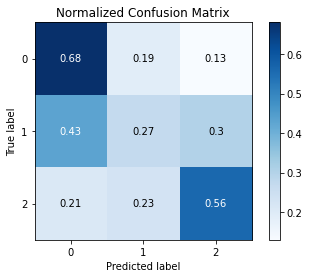

In [37]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [38]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["Low", "Moderate", "High"]))

              precision    recall  f1-score   support

         Low       0.78      0.68      0.73      1982
    Moderate       0.32      0.27      0.29       769
        High       0.22      0.56      0.32       249

    accuracy                           0.56      3000
   macro avg       0.44      0.50      0.45      3000
weighted avg       0.61      0.56      0.58      3000



In [39]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

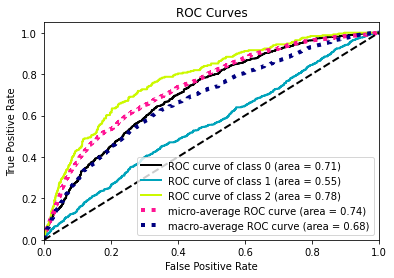

In [41]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

In [42]:
model = LogisticRegression()

In [43]:
grid_vals = {'penalty': ['l2'], 'C': [0.01,0.1], 'max_iter':[100, 150, 200, 300], 'solver':['newton-cg', 'lbfgs', 'saga']}
# grid_vals = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [44]:
y_train = y_train.astype("float")

In [45]:
grid_lr.fit(X_train, y_train)

/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=3, error_score='raise', estimator=LogisticRegression(),
             n_jobs=4,
             param_grid={'C': [0.01, 0.1], 'max_iter': [100, 150, 200, 300],
                         'penalty': ['l2'],
                         'solver': ['newton-cg', 'lbfgs', 'saga']},
             return_train_score=True, scoring='f1_micro')

In [46]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        1.241327      0.044745         0.004658        0.000854    0.01   
1        0.279423      0.001239         0.005694        0.000319    0.01   
2        0.930612      0.057439         0.004197        0.000923    0.01   
3        1.025423      0.159292         0.003976        0.000663    0.01   
4        0.358547      0.042520         0.005002        0.000892    0.01   
5        1.454539      0.148317         0.004634        0.000909    0.01   
6        1.044691      0.186664         0.004138        0.001009    0.01   
7        0.502316      0.018346         0.005037        0.000259    0.01   
8        1.687406      0.016362         0.004246        0.001015    0.01   
9        0.929992      0.157202         0.004064        0.000917    0.01   
10       0.746767      0.006000         0.005213        0.000374    0.01   
11       2.536954      0.023793         0.004452        0.000756    0.01   
12       1.085570      0.046495         0.003337        0.000177     0.1   
13       0.257865      0.002587         0.004892        0.001010     0.1   
14       0.979141      0.171462         0.004990        0.000445     0.1   
15       1.645808      0.008034         0.005346        0.000369     0.1   
16       0.406928      0.005573         0.005016        0.001124     0.1   
17       1.268621      0.016133         0.004469        0.000704     0.1   
18       1.303375      0.153963         0.003403        0.000135     0.1   
19       0.464035      0.050483         0.004973        0.000867     0.1   
20       1.906367      0.097686         0.004565        0.000635     0.1   
21       1.350131      0.183771         0.003937        0.000599     0.1   
22       0.742164      0.032323         0.004828        0.001013     0.1   
23       2.452517      0.047244         0.003796        0.000443     0.1   

   param_max_iter param_penalty param_solver  \
0             100            l2    newton-cg   
1             100            l2        lbfgs   
2             100            l2         saga   
3             150            l2    newton-cg   
4             150            l2        lbfgs   
5             150            l2         saga   
6             200            l2    newton-cg   
7             200            l2        lbfgs   
8             200            l2         saga   
9             300            l2    newton-cg   
10            300            l2        lbfgs   
11            300            l2         saga   
12            100            l2    newton-cg   
13            100            l2        lbfgs   
14            100            l2         saga   
15            150            l2    newton-cg   
16            150            l2        lbfgs   
17            150            l2         saga   
18            200            l2    newton-cg   
19            200            l2        lbfgs   
20            200            l2         saga   
21            300            l2    newton-cg   
22            300            l2        lbfgs   
23            300            l2         saga   

                                               params  split0_test_score  \
0   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.523899   
1   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.507508   
2   {'C': 0.01, 'max_iter': 100, 'penalty': 'l2', ...           0.464715   
3   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.523899   
4   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.507633   
5   {'C': 0.01, 'max_iter': 150, 'penalty': 'l2', ...           0.476602   
6   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.523899   
7   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.518393   
8   {'C': 0.01, 'max_iter': 200, 'penalty': 'l2', ...           0.483984   
9   {'C': 0.01, 'max_iter': 300, 'penalty': 'l2', ...           0.523899   
10  {'C': 0.01, 'max_iter': 300, 'penalty': 'l2', ...           0.

In [47]:
grid_lr.best_estimator_

LogisticRegression(C=0.1, solver='newton-cg')

In [48]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

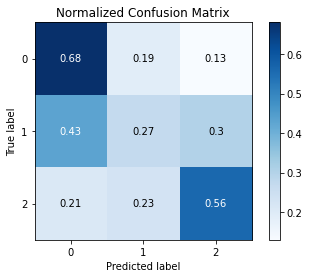

In [49]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [50]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["Low", "Moderate", "High"]))

              precision    recall  f1-score   support

         Low       0.78      0.68      0.73      1982
    Moderate       0.32      0.27      0.29       769
        High       0.22      0.56      0.32       249

    accuracy                           0.56      3000
   macro avg       0.44      0.50      0.45      3000
weighted avg       0.61      0.56      0.58      3000



In [51]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

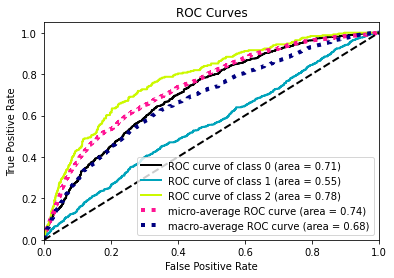

In [52]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

### SVM Classifier

In [ ]:
model = SVC()

In [ ]:
grid_vals = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf', 'sigmoid', 'poly'],
            'degree':[2,3,4]} 

In [ ]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [ ]:
grid_lr.fit(X_train, y_train)

In [ ]:
pd.DataFrame(grid_lr.cv_results_)

In [ ]:
grid_lr.best_estimator_

In [ ]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

In [ ]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [ ]:
y_pred = grid_lr.predict_proba(X_test)

In [ ]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

### XGBoost

In [227]:
model = XGBClassifier()
grid_vals = {"n_estimators":[500,600,700], "learning_rate" : [0.1, 0.01], "max_depth" : [2,3,4], "subsample":[0.8,0.9],
                      "colsample_bytree":[0.8,0.9], 'reg_alpha':[1e-5, 1e-2]}

In [228]:
# grid_vals = {'penalty': ['l2'], 'C': [0.01,0.1], 'max_iter':[100, 150, 200, 300], 'solver':['newton-cg', 'lbfgs', 'saga']}
# grid_vals = {'penalty': ['l2'], 'C': [0.001,0.01,0.1,1]}
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='roc_auc_ovr', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=-1)

In [229]:
grid_lr.fit(X_train, y_train)
# grid_lr.fit(X_resampled, y_resampled)

GridSearchCV(cv=3, error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.1, 0.01], 'max_depth': [2, 3, 4],
                         'n_estimators': [500, 600, 700],
                         'reg_alpha': [1e-05, 0.01], 'subsample': [0.8, 0.9]},
             return_train_score=True, scoring='roc_auc_ovr')

In [230]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        13.836807      0.528911         0.066671        0.001059   
1        13.641476      0.551541         0.065918        0.000416   
2        13.813501      0.512125         0.068027        0.002731   
3        13.624272      0.582070         0.065714        0.000919   
4        16.735596      0.630229         0.079689        0.003278   
5        16.520114      0.748777         0.078245        0.000793   
6        16.716070      0.627632         0.077482        0.000751   
7        16.539457      0.650004         0.079668        0.002383   
8        19.379833      0.745781         0.090250        0.000526   
9        19.344232      0.728349         0.090181        0.000111   
10       19.429474      0.735355         0.089511        0.000862   
11       19.220129      0.797519         0.089130        0.000358   
12       20.517979      0.811797         0.107269        0.000511   
13       20.301239      0.952077         0.106393        0.000149   
14       20.503340      0.836953         0.108304        0.001366   
15       20.306077      0.929844         0.107469        0.001262   
16       24.999556      0.939395         0.128520        0.001345   
17       24.651090      1.125450         0.128803        0.000468   
18       24.935716      0.997587         0.128303        0.000265   
19       24.696651      1.133530         0.129608        0.000648   
20       29.569103      1.388974         0.150863        0.001676   
21       29.123618      1.291314         0.148530        0.002438   
22       29.537064      1.132453         0.149725        0.001184   
23       29.130968      1.363071         0.147132        0.001149   
24       28.034640      1.095800         0.163796        0.000589   
25       27.849827      1.241171         0.166156        0.000978   
26       28.058338      1.093172         0.165473        0.003103   
27       27.819565      1.303388         0.165286        0.001852   
28       33.689493      1.261047         0.195417        0.001531   
29       33.462424      1.505136         0.199411        0.004367   
30       33.766057      1.395154         0.197347        0.000831   
31       33.481685      1.497096         0.197348        0.001824   
32       39.418112      1.537297         0.230114        0.002653   
33       39.029104      1.823506         0.234760        0.002821   
34       39.545941      1.495573         0.231805        0.003041   
35       39.054273      1.751281         0.234472        0.007966   
36       14.626356      0.521078         0.073350        0.001607   
37       14.447945      0.581563         0.072983        0.001462   
38       14.684907      0.526371         0.074383        0.001720   
39       14.527584      0.581758         0.072490        0.000447   
40       17.629117      0.667578         0.083668        0.000809   
41       17.413929      0.731509         0.084642        0.000919   
42       17.638485      0.676010         0.086157        0.001087   
43       17.478087      0.903915         0.083309        0.000668   
44       20.530857      0.819013         0.096002        0.000147   
45       20.272122      0.913330         0.097781        0.002516   
46       20.518668      0.777206         0.098484        0.001806   
47       20.283043      0.851369         0.097501        0.001691   
48       21.502016      0.834369         0.113609        0.001665   
49       21.257725      0.956448         0.115500        0.003283   
50       21.504046      0.828911         0.114804        0.000365   
51       21.316097      0.959878         0.113016        0.002332   
52       25.872468      0.953265         0.140791        0.004732   
53       25.506806      1.105297         0.134456        0.001663   
54       25.792481      1.042534         0.135718        0.002573   
55       25.525582      1.113130         0.132863        0.000098   
56       30.157137      1.151447         0.153254        0.002103   
57 

In [231]:
grid_lr.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=700, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto', ...)

In [232]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred, "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

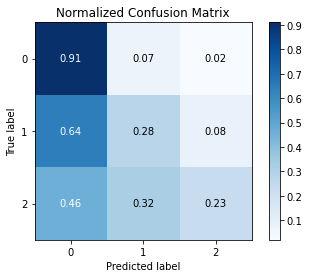

In [233]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [234]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["Low", "Moderate", "High"]))

              precision    recall  f1-score   support

         Low       0.76      0.91      0.83      2037
    Moderate       0.48      0.28      0.35       724
        High       0.36      0.23      0.28       239

    accuracy                           0.70      3000
   macro avg       0.53      0.47      0.49      3000
weighted avg       0.66      0.70      0.67      3000



In [235]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

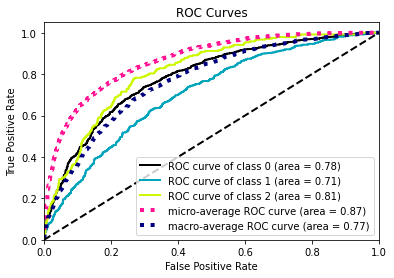

In [236]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

Text(0, 0.5, 'Features')

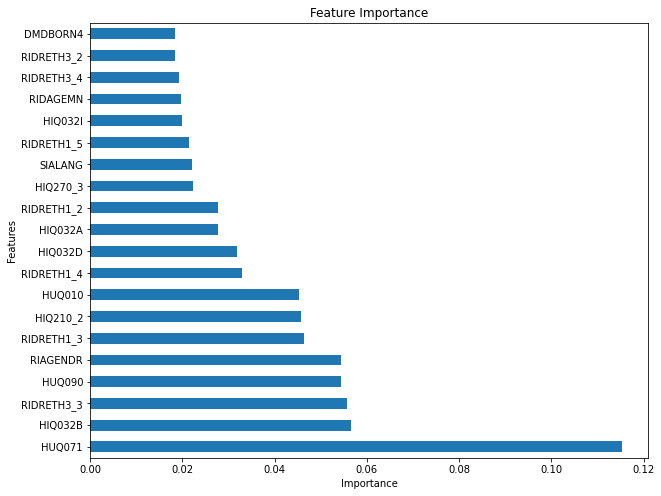

In [237]:
feat_importances = pd.Series(grid_lr.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

### LightGBM

In [238]:
model = LGBMClassifier()

In [239]:
grid_vals = {'learning_rate': [0.01, 0.1], 'n_estimators': [100, 200, 300],
               'num_leaves': [6, 12, 16,24], 'boosting_type': ['gbdt', 'dart'], 
               'colsample_bytree': [0.65, 0.75, 0.8], 
               'subsample': [0.7, 0.75], 'reg_alpha': [1e-5, 1e-2],
               'reg_lambda': [1e-5, 1e-2]}

In [240]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [241]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise', estimator=LGBMClassifier(), n_jobs=4,
             param_grid={'boosting_type': ['gbdt', 'dart'],
                         'colsample_bytree': [0.65, 0.75, 0.8],
                         'learning_rate': [0.01, 0.1],
                         'n_estimators': [100, 200, 300],
                         'num_leaves': [6, 12, 16, 24],
                         'reg_alpha': [1e-05, 0.01],
                         'reg_lambda': [1e-05, 0.01],
                         'subsample': [0.7, 0.75]},
             return_train_score=True, scoring='f1_micro')

In [242]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0          0.247873      0.003545         0.026349        0.000928   
1          0.247053      0.002099         0.023590        0.000911   
2          0.246996      0.005169         0.026217        0.002037   
3          0.247005      0.002950         0.025427        0.002866   
4          0.246351      0.001922         0.024080        0.001023   
...             ...           ...              ...             ...   
1147       4.848143      0.230569         0.139806        0.006090   
1148       4.803494      0.162881         0.142262        0.005944   
1149       4.812373      0.187365         0.142353        0.004584   
1150       4.828876      0.196243         0.140239        0.006143   
1151       4.710304      0.258334         0.121553        0.014654   

     param_boosting_type param_colsample_bytree param_learning_rate  \
0                   gbdt                   0.65                0.01   
1                   gbdt                   0.65                0.01   
2                   gbdt                   0.65                0.01   
3                   gbdt                   0.65                0.01   
4                   gbdt                   0.65                0.01   
...                  ...                    ...                 ...   
1147                dart                    0.8                 0.1   
1148                dart                    0.8                 0.1   
1149                dart                    0.8                 0.1   
1150                dart                    0.8                 0.1   
1151                dart                    0.8                 0.1   

     param_n_estimators param_num_leaves param_reg_alpha param_reg_lambda  \
0                   100                6         0.00001          0.00001   
1                   100                6         0.00001          0.00001   
2                   100                6         0.00001             0.01   
3                   100                6         0.00001             0.01   
4                   100                6            0.01          0.00001   
...                 ...              ...             ...              ...   
1147                300               24         0.00001             0.01   
1148                300               24            0.01          0.00001   
1149                300               24            0.01          0.00001   
1150                300               24            0.01             0.01   
1151                300               24            0.01             0.01   

     param_subsample                                             params  \
0                0.7  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
1               0.75  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
2                0.7  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
3               0.75  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
4                0.7  {'boosting_type': 'gbdt', 'colsample_bytree': ...   
...              ...                                                ...   
1147            0.75  {'boosting_type': 'dart', 'colsample_bytree': ...   
1148             0.7  {'boosting_type': 'dart', 'colsample_bytree': ...   
1149            0.75  {'boosting_type': 'dart', 'colsample_bytree': ...   
1150             0.7  {'boosting_type': 'dart', 'colsample_bytree': ...   
1151            0.75  {'boosting_type': 'dart', 'colsample_bytree': ...   

      split0_test_score  split1_test_score  split2_test_score  \
0              0.545420           0.643442           0.632985   
1              0.545420           0.643442           0.632985   
2              0.545420           0.643442           0.632985   
3              0.545420           0.643442           0.632985   
4              0.545420           0.643442           0.632985   
...                 ...                ...                ...   
1147           0.536475        

In [243]:
grid_lr.best_estimator_

LGBMClassifier(colsample_bytree=0.8, n_estimators=300, num_leaves=24,
               reg_alpha=0.01, reg_lambda=1e-05, subsample=0.7)

In [244]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

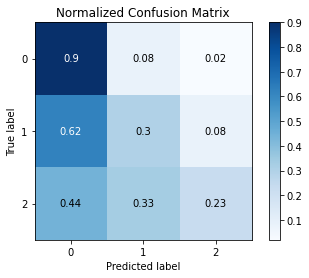

In [245]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [246]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["Low", "Moderate", "High"]))

              precision    recall  f1-score   support

         Low       0.77      0.90      0.83      2037
    Moderate       0.46      0.30      0.36       724
        High       0.37      0.23      0.28       239

    accuracy                           0.70      3000
   macro avg       0.53      0.48      0.49      3000
weighted avg       0.66      0.70      0.67      3000



In [247]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

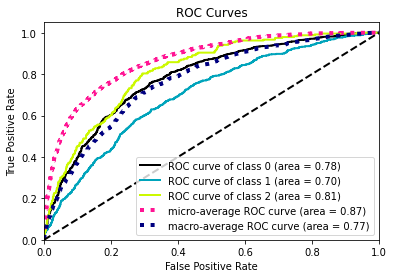

In [248]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

Text(0, 0.5, 'Features')

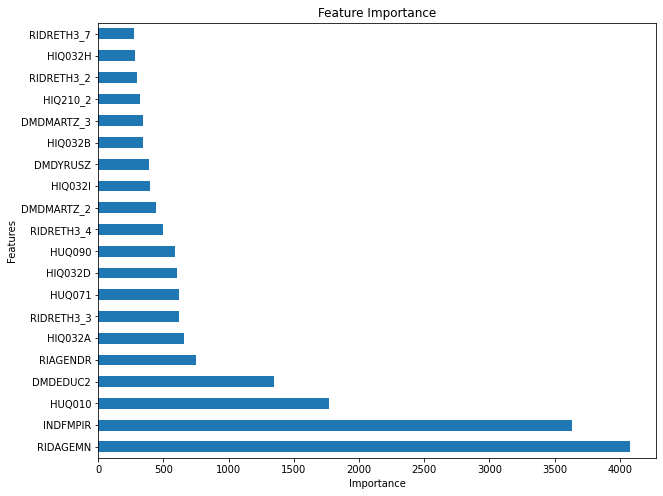

In [249]:
feat_importances = pd.Series(grid_lr.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

### Random Forest Classifier

In [250]:
model = RandomForestClassifier()

In [251]:
grid_vals = {'n_estimators': [150, 200, 300],
             'criterion':['gini', 'entropy', 'log_loss'], 'max_depth': [2,4,6,8],
             'min_samples_split':[2,4], 'min_samples_leaf':[1,2],
             'max_features':[0.85,0.9,0.95]}

In [252]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=-1) 

In [253]:
y_train = y_train.astype(int)

In [254]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise', estimator=RandomForestClassifier(),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': [0.85, 0.9, 0.95],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 4],
                         'n_estimators': [150, 200, 300]},
             return_train_score=True, scoring='f1_micro')

In [255]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         1.974369      0.154649         0.061471        0.000961   
1         2.635858      0.217637         0.080476        0.001148   
2         3.959253      0.324269         0.119311        0.001406   
3         1.968206      0.165704         0.062581        0.000244   
4         2.644141      0.208338         0.080988        0.000973   
..             ...           ...              ...             ...   
427      12.389470      1.398160         0.125525        0.002868   
428      17.275119      1.677777         0.160316        0.006802   
429       9.296781      1.088925         0.095100        0.002263   
430      11.104373      1.145557         0.107372        0.001968   
431      14.518205      1.649977         0.152252        0.004188   

    param_criterion param_max_depth param_max_features param_min_samples_leaf  \
0              gini               2               0.85                      1   
1              gini               2               0.85                      1   
2              gini               2               0.85                      1   
3              gini               2               0.85                      1   
4              gini               2               0.85                      1   
..              ...             ...                ...                    ...   
427        log_loss               8               0.95                      2   
428        log_loss               8               0.95                      2   
429        log_loss               8               0.95                      2   
430        log_loss               8               0.95                      2   
431        log_loss               8               0.95                      2   

    param_min_samples_split param_n_estimators  \
0                         2                150   
1                         2                200   
2                         2                300   
3                         4                150   
4                         4                200   
..                      ...                ...   
427                       2                200   
428                       2                300   
429                       4                150   
430                       4                200   
431                       4                300   

                                                params  split0_test_score  \
0    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.473731   
1    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.489984   
2    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.473731   
3    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.473731   
4    {'criterion': 'gini', 'max_depth': 2, 'max_fea...           0.473731   
..                                                 ...                ...   
427  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.547184   
428  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.545420   
429  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.548318   
430  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.548444   
431  {'criterion': 'log_loss', 'max_depth': 8, 'max...           0.546428   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.526017           0.525387         0.508378        0.024501   
1             0.527403           0.525387         0.514258        0.017184   
2             0.525891           0.525387         0.508336        0.024471   
3             0.530931           0.525387         0.510016        0.025758   
4             0.528915           0.525387         0.509344        0.025224   
..                 ...                ...              ...             ...   
427           0.700769           0.663097         0.637017        0.065356   
428           0.695855           0.668893         0.6

In [256]:
grid_lr.best_estimator_

RandomForestClassifier(max_depth=8, max_features=0.9, min_samples_leaf=2,
                       min_samples_split=4, n_estimators=200)

In [257]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

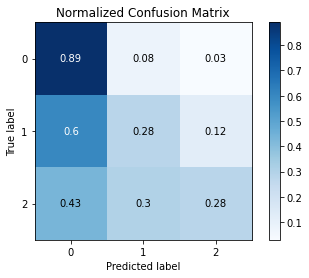

In [258]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [259]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["Low", "Moderate", "High"]))

              precision    recall  f1-score   support

         Low       0.77      0.89      0.82      2037
    Moderate       0.46      0.28      0.35       724
        High       0.30      0.28      0.29       239

    accuracy                           0.69      3000
   macro avg       0.51      0.48      0.49      3000
weighted avg       0.66      0.69      0.67      3000



In [260]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

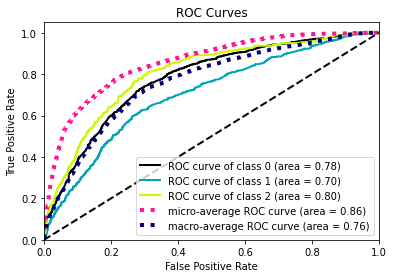

In [261]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

Text(0, 0.5, 'Features')

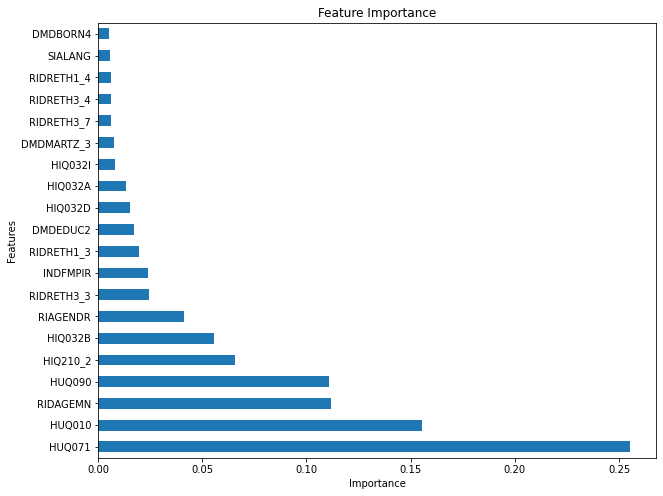

In [262]:
feat_importances = pd.Series(grid_lr.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")

### MLP

In [86]:
df

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0      109263        66         2         0         2        24         5   
1      109264        66         2         1        13       156         1   
2      109265        66         2         0         2        24         3   
3      109266        66         2         1        29       348         5   
4      109267        66         1         1        21       252         2   
...       ...       ...       ...       ...       ...       ...       ...   
15393  124818        66         2         0        40       480         4   
15394  124819        66         2         0         2        24         4   
15395  124820        66         2         1         7        84         3   
15396  124821        66         2         0        63       756         4   
15397  124822        66         2         0        74       888         2   

       RIDRETH3  DMDBORN4  DMDYRUSZ  DMDEDUC2  DMDMARTZ  RIDEXPRG  SIALANG  \
0             6         0         5         6         4         4        0   
1             1         0         5         6         4         4        0   
2             3         0         5         6         4         4        0   
3             6         1         2         5         3         2        0   
4             2         1         3         4         3         3        0   
...         ...       ...       ...       ...       ...       ...      ...   
15393         4         0         5         5         1         4        0   
15394         4         0         5         6         4         4        0   
15395         3         0         5         6         4         4        0   
15396         4         0         5         2         2         4        0   
15397         2         1         4         3         1         4        1   

       SIAPROXY  SIAINTRP  INDFMPIR  HUQ010  HUQ030  HUQ051  HUQ071  HUQ090  \
0             1         0      4.66       1       1       0       0       0   
1             1         0      0.83       2       1       0       0       1   
2             1         0      3.06       1       1       0       0       0   
3             0         0      5.00       3       1       0       0       0   
4             0         0      5.00       1       2       0       0       0   
...         ...       ...       ...     ...     ...     ...     ...     ...   
15393         0         0      3.82       2       1       0       0       0   
15394         1         0      0.07       3       1       1       0       0   
15395         1         0      1.22       1       1       0       0       0   
15396         0         0      3.71       3       1       0       0       0   
15397         0         0      0.82       3       1       0       0       0   

       HIQ011  HIQ032A  HIQ032B  HIQ032C  HIQ032D  HIQ032E  HIQ032H  HIQ032I  \
0           1        0        0        0        0        0        0        0   
1           1        1        0        0        0        0        1        0   
2           1        0        0        0        1        0        0        0   
3           1        0        0        0        0        0        0        0   
4           1        0        0        0        0        0        0        0   
...       ...      ...      ...      ...      ...      ...      ...      ...   
15393       1        0        0        0        0        0        0        0   
15394       1        1        0        0        1        0        0        0   
15395       1        1        0        0        1        0        0        0   
15396       0        1        0        0        0        0        0        0   
15397       1        1        1        0        0        0        0        0   

       HIQ270  HIQ210  
0           1       2  
1           1       2  
2           1       2  
3           1       2  
4           1       2  
...       ...     ...  
15393       1       2  
15394       1       2  
15395       1       2

In [87]:
X, y = df[df.columns[df.columns != target_col]], df[target_col]

In [88]:
X[numeric_cols + ordinal_cols] = MinMaxScaler().fit_transform(X[numeric_cols + ordinal_cols_wo_Target])

In [89]:
df_l = pd.concat([X, y], axis = 1)

In [90]:
df_dum = pd.get_dummies(df_l[demo_cols + hiq_cols + huq_cols], columns = [col for col in one_hot_enc_cols if col in demo_cols + huq_cols + hiq_cols], drop_first = True)

In [91]:
X_train, X_test, y_train, y_test = train_test_split(df_dum[df_dum.columns[df_dum.columns != target_col]], 
                                                    df_dum[target_col], 
                                                    test_size=0.20
                                                    )

In [92]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)
    
for col in X_test.columns:
    X_test[col] = X_test[col].astype(float)

In [93]:
model = MLPClassifier()

In [94]:
grid_vals = {'hidden_layer_sizes': [(50,), (100,), (150)],
             'activation':['relu', 'identity', 'logistic', 'tanh'],
             'solver':['lbfgs', 'sgd', 'adam'],
             'alpha':[0.001, 0.01],
             'learning_rate':['constant', 'adaptive'],
             'max_iter':[200, 300],
             'early_stopping':[True, False]}

In [95]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=-1) 

In [96]:
y_train = y_train.astype(int)

In [97]:
grid_lr.fit(X_train, y_train)

/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  warnings.warn(
/home/jupyter-risaac/.local/lib/python3.

GridSearchCV(cv=3, error_score='raise', estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu', 'identity', 'logistic', 'tanh'],
                         'alpha': [0.001, 0.01],
                         'early_stopping': [True, False],
                         'hidden_layer_sizes': [(50,), (100,), 150],
                         'learning_rate': ['constant', 'adaptive'],
                         'max_iter': [200, 300],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             return_train_score=True, scoring='f1_micro')

In [98]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         3.071772      0.072954         0.006380        0.000619   
1         0.658752      0.349533         0.007907        0.000903   
2         0.503793      0.236923         0.006803        0.000747   
3         4.847377      0.187122         0.005700        0.000326   
4         0.391119      0.138913         0.006464        0.000546   
..             ...           ...              ...             ...   
571      10.771467      0.651301         0.018488        0.000433   
572       9.823476      1.261696         0.019183        0.000570   
573      13.745174      0.025733         0.010310        0.000549   
574       9.278121      0.111366         0.016791        0.003973   
575      12.393446      0.588905         0.009578        0.000166   

    param_activation param_alpha param_early_stopping  \
0               relu       0.001                 True   
1               relu       0.001                 True   
2               relu       0.001                 True   
3               relu       0.001                 True   
4               relu       0.001                 True   
..               ...         ...                  ...   
571             tanh        0.01                False   
572             tanh        0.01                False   
573             tanh        0.01                False   
574             tanh        0.01                False   
575             tanh        0.01                False   

    param_hidden_layer_sizes param_learning_rate param_max_iter param_solver  \
0                      (50,)            constant            200        lbfgs   
1                      (50,)            constant            200          sgd   
2                      (50,)            constant            200         adam   
3                      (50,)            constant            300        lbfgs   
4                      (50,)            constant            300          sgd   
..                       ...                 ...            ...          ...   
571                      150            adaptive            200          sgd   
572                      150            adaptive            200         adam   
573                      150            adaptive            300        lbfgs   
574                      150            adaptive            300          sgd   
575                      150            adaptive            300         adam   

                                                params  split0_test_score  \
0    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.651413   
1    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.678170   
2    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.681170   
3    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.652163   
4    {'activation': 'relu', 'alpha': 0.001, 'early_...           0.668667   
..                                                 ...                ...   
571  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.679670   
572  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.674669   
573  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.647912   
574  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.678670   
575  {'activation': 'tanh', 'alpha': 0.01, 'early_s...           0.666667   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0             0.670918           0.665416         0.662582        0.008211   
1             0.668917           0.668417         0.671835        0.004484   
2             0.674169           0.680170         0.678503        0.003092   
3             0.654164           0.658915         0.655080        0.002832   
4             0.666917           0.668417         0.668000        0.000773   
..                 ...                ...              ...             ...   
571           0.682671           0.685671         0.682671 

In [99]:
grid_lr.best_estimator_

MLPClassifier(alpha=0.001, early_stopping=True)

In [100]:
y_pred = grid_lr.predict(X_test)
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

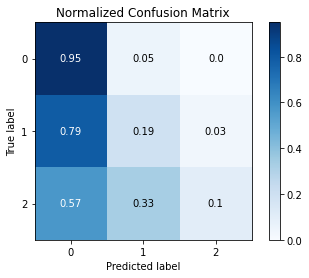

In [101]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [102]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["Low", "Moderate", "High"]))

              precision    recall  f1-score   support

         Low       0.71      0.95      0.81      1955
    Moderate       0.43      0.19      0.26       752
        High       0.59      0.10      0.17       293

    accuracy                           0.68      3000
   macro avg       0.58      0.41      0.42      3000
weighted avg       0.63      0.68      0.61      3000



In [103]:
y_pred = grid_lr.predict_proba(X_test)

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

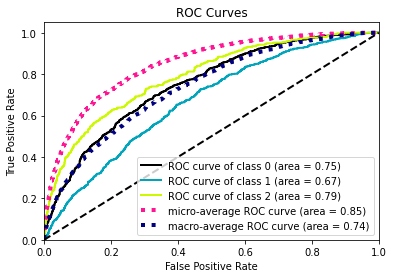

In [104]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

### CatBoost

In [149]:
df[nominal_cols + ordinal_cols + numeric_cols]

RIAGENDR  RIDRETH3  DMDBORN4  DMDMARTZ  RIDEXPRG  SIALANG  SIAPROXY  \
0             0         6         0         4         4        0         1   
1             1         1         0         4         4        0         1   
2             0         3         0         4         4        0         1   
3             1         6         1         3         2        0         0   
4             1         2         1         3         3        0         0   
...         ...       ...       ...       ...       ...      ...       ...   
15393         0         4         0         1         4        0         0   
15394         0         4         0         4         4        0         1   
15395         1         3         0         4         4        0         1   
15396         0         4         0         2         4        0         0   
15397         0         2         1         1         4        1         0   

       SIAINTRP  HUQ030  HUQ071  HUQ090  HIQ011  HIQ032A  HIQ032B  HIQ032C  \
0             0       1       0       0       1        0        0        0   
1             0       1       0       1       1        1        0        0   
2             0       1       0       0       1        0        0        0   
3             0       1       0       0       1        0        0        0   
4             0       2       0       0       1        0        0        0   
...         ...     ...     ...     ...     ...      ...      ...      ...   
15393         0       1       0       0       1        0        0        0   
15394         0       1       0       0       1        1        0        0   
15395         0       1       0       0       1        1        0        0   
15396         0       1       0       0       0        1        0        0   
15397         0       1       0       0       1        1        1        0   

       HIQ032D  HIQ032E  HIQ032H  HIQ032I  HIQ270  HIQ210  DMDYRUSZ  DMDEDUC2  \
0            0        0        0        0       1       2         5         6   
1            0        0        1        0       1       2         5         6   
2            1        0        0        0       1       2         5         6   
3            0        0        0        0       1       2         2         5   
4            0        0        0        0       1       2         3         4   
...        ...      ...      ...      ...     ...     ...       ...       ...   
15393        0        0        0        0       1       2         5         5   
15394        1        0        0        0       1       2         5         6   
15395        1        0        0        0       1       2         5         6   
15396        0        0        0        0       3       3         5         2   
15397        0        0        0        0       2       2         4         3   

       HUQ010  RIDAGEYR  RIDAGEMN  INDFMPIR  
0           1         2        24      4.66  
1           2        13       156      0.83  
2           1         2        24      3.06  
3           3        29       348      5.00  
4           1        21       252      5.00  
...       ...       ...       ...       ...  
15393       2        40       480      3.82  
15394       3         2        24      0.07  
15395       1         7        84      1.22  
15396       3        63       756      3.71  
15397       3        74       888      0.82  

[14997 rows x 27 columns]

In [157]:
X_train, X_test, y_train, y_test = train_test_split(df[nominal_cols + ordinal_cols + numeric_cols], 
                                                    df[target_col], 
                                                    test_size=0.20
                                                    )

In [158]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(float)
    
for col in X_test.columns:
    X_test[col] = X_test[col].astype(float)

In [159]:
model = CatBoostClassifier()

In [160]:
grid_vals = {'learning_rate': [0.01, 0.1], 'iterations': [50, 100, 150],
             'loss_function': ['MultiClass', 'MultiClassOneVsAll'],
#                'num_leaves': [6, 12, 16], 
#                'colsample_bylevel': [0.75, 0.8], 
             'logging_level':['Silent'],
#                'subsample': [0.7, 0.8], 
             'l2_leaf_reg': [1e-5, 1e-2],
            'depth'         : [4,5,6],
            "classes_count":[3]}


In [188]:
grid_lr = GridSearchCV(estimator=model, param_grid=grid_vals, scoring='f1_micro', 
                       cv=3, refit=True, return_train_score=True, error_score='raise', n_jobs=4) 

In [168]:
# create categorical feature indices for catboost
cat_features = []
for col in nominal_cols + ordinal_cols:
    
    if col == target_col:
        continue
    cat_features.append(X_train.columns.get_loc(col))
    

In [170]:
X_train = X_train.astype(int)

In [186]:
y_train = y_train.astype(int)

In [189]:
grid_lr.fit(X_train, y_train, cat_features=cat_features)

GridSearchCV(cv=3, error_score='raise',
             estimator=<catboost.core.CatBoostClassifier object at 0x7ff5cdc90040>,
             n_jobs=4,
             param_grid={'classes_count': [3], 'depth': [4, 5, 6],
                         'iterations': [50, 100, 150],
                         'l2_leaf_reg': [1e-05, 0.01],
                         'learning_rate': [0.01, 0.1],
                         'logging_level': ['Silent'],
                         'loss_function': ['MultiClass', 'MultiClassOneVsAll']},
             return_train_score=True, scoring='f1_micro')

In [190]:
pd.DataFrame(grid_lr.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.905946      0.078373         0.023948        0.014894   
1        0.783692      0.110352         0.045115        0.016280   
2        0.966786      0.150685         0.027563        0.011379   
3        0.855985      0.101988         0.043419        0.027662   
4        0.864496      0.040837         0.020798        0.004030   
5        0.745849      0.032255         0.022761        0.016213   
6        0.681633      0.030523         0.019265        0.010626   
7        0.710895      0.001619         0.026276        0.001676   
8        1.292975      0.097808         0.039110        0.015822   
9        1.378960      0.109198         0.039266        0.013729   
10       1.313198      0.183336         0.045185        0.016191   
11       1.456503      0.047032         0.039503        0.021465   
12       1.321562      0.136089         0.043762        0.026300   
13       1.383600      0.237829         0.074605        0.046966   
14       2.866806      0.647316         0.095604        0.037268   
15       6.099311      0.241814         0.124217        0.009081   
16       8.438413      0.266002         0.140830        0.008147   
17       8.644952      0.117934         0.107063        0.052278   
18       8.470189      0.757077         0.136054        0.047786   
19       9.037628      0.156237         0.098155        0.046917   
20       8.320885      0.167868         0.122582        0.014883   
21       8.294042      0.153869         0.093312        0.018823   
22       8.148576      0.809435         0.088307        0.012946   
23       8.707863      0.221274         0.100910        0.013263   
24       3.363188      0.125133         0.091963        0.055478   
25       3.343848      0.169619         0.119757        0.023536   
26       3.112854      0.418870         0.104588        0.013725   
27       3.318745      0.146490         0.082733        0.036617   
28       3.169850      0.186077         0.107033        0.040146   
29       3.513376      0.248078         0.124675        0.025192   
30       3.535754      0.029505         0.091899        0.039924   
31       3.186657      0.138431         0.095785        0.021866   
32       6.626235      0.440679         0.095204        0.006451   
33       7.142825      0.455654         0.125278        0.032669   
34       6.950680      0.187541         0.112815        0.023713   
35       6.346986      0.253373         0.062260        0.004701   
36       6.942753      0.416460         0.103961        0.044823   
37       7.148647      0.208737         0.124537        0.022044   
38       6.839589      0.216508         0.106429        0.024859   
39       6.983466      0.283881         0.116181        0.019697   
40      10.131240      0.196845         0.110569        0.065037   
41      10.126395      0.421983         0.102150        0.031505   
42      10.135928      0.312558         0.055427        0.014059   
43      10.079495      0.424303         0.101028        0.031542   
44      10.200762      0.797656         0.088329        0.038595   
45      10.457431      0.627149         0.074914        0.042819   
46      10.460318      0.320550         0.121577        0.052362   
47      10.668733      0.593175         0.083118        0.033270   
48       4.285844      0.107821         0.092027        0.045490   
49       4.135361      0.127263         0.076061        0.004135   
50       4.252159      0.164141         0.081439        0.024289   
51       4.131589      0.166403         0.079702        0.012937   
52       4.248970      0.452741         0.086080        0.023524   
53       4.167247      0.311470         0.074247        0.024939   
54       4.225072      0.285639         0.091724        0.023886   
55       4.355603      0.140847         0.050273        0.009542   
56       3.713880      0.822393         0.038545        0.014141   
57       1.990807      0.622880         0.030476        0.01

In [191]:
grid_lr.best_estimator_

In [194]:
y_pred = grid_lr.predict(X_test.astype(int))
out = pd.DataFrame({"y_pred":y_pred.flatten(), "y_label":y_test})

<AxesSubplot:title={'center':'Normalized Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

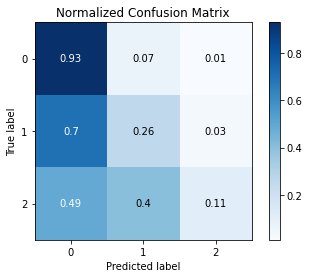

In [195]:
skplt.metrics.plot_confusion_matrix(out["y_label"].tolist(), out["y_pred"].tolist(), normalize=True)

In [196]:
print(classification_report(out["y_label"].tolist(), out["y_pred"].tolist(), target_names=["Low", "Moderate", "High"]))

              precision    recall  f1-score   support

         Low       0.74      0.93      0.82      2002
    Moderate       0.45      0.26      0.33       729
        High       0.43      0.11      0.17       269

    accuracy                           0.69      3000
   macro avg       0.54      0.43      0.44      3000
weighted avg       0.64      0.69      0.65      3000



In [198]:
y_pred = grid_lr.predict_proba(X_test.astype(int))

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

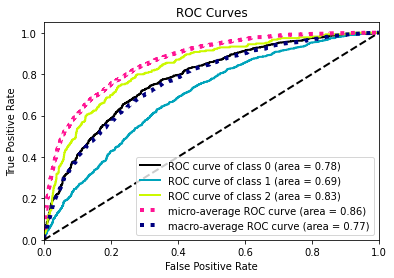

In [199]:
skplt.metrics.plot_roc(y_test.tolist(), y_pred)

Text(0, 0.5, 'Features')

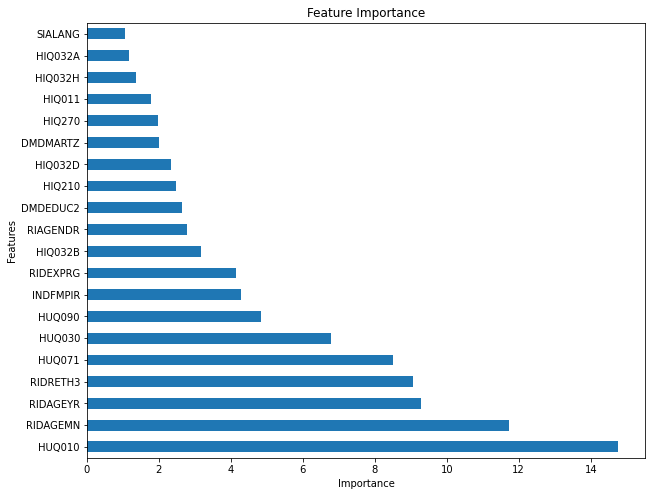

In [202]:
feat_importances = pd.Series(grid_lr.best_estimator_.feature_importances_, index=X_train.columns)
feat_importances.nlargest(20).plot(kind='barh', figsize=(10,8))
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Features")